In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
class DataLoad():
    def __init__(self, model:str, topic:str, data_path:str, rev_topic: bool=False, probing: int=0):
        self.model = model
        self.topic = topic
        self.path = data_path

        if rev_topic:
            self.topic += ' (Rev. Framing)'

        self.R = np.load(data_path + 'all_R.npy')
        self.probs = np.load(data_path + 'all_probs.npy')

        ### remove external probing for now:
        self.R = self.R[:,:,:,:, probing,:]

        self.mask = (self.R[:, :, :, :, 0] == -1)
        print(f"Irregular Runs: {self.mask.sum() / np.prod(self.R.shape[:3]) * 100:0.2f} %")
        self.R[self.mask] = np.nan

    def print_datashape(self):
        print("(#pairs, #runs, #discussion_rounds + 1 init round, #agents, #features)\n", self.R.shape)

In [3]:
all_topics = ['"Climate Change is an important\nproblem to address"', 'Artificial Intelligence\nis dangerous', 'The global distribution\nof wealth is fair', '']
all_models = ['dolphin_mixtral', 'mixtral_8x7b', 'gpt_4o_mini']

llm_idx = 0 # choose model
model = all_models[llm_idx] # choose model

base_path = f'../../data/simulations/raw/{model}/'
paths = ['climate_change', 'ai_dangers', 'wealth_distribution', 'climate_change_rev', 'ai_dangers_rev', 'wealth_distribution_rev']

In [4]:
all_grids = np.zeros((6, 4, 100, 100))

for p, path in enumerate(paths):
    data = DataLoad(model, all_topics[p // 2], base_path + path + '/', p % 2 == 1)

    start_positions = data.R[:, :, 0, :, 0] - 3
    end_positions = data.R[:, :, -1, :, 0] - 3

    # Flatten arrays for interpolation
    X_start = start_positions[..., 0].flatten()
    Y_start = start_positions[..., 1].flatten()
    U = (end_positions[..., 0] - start_positions[..., 0]).flatten()
    V = (end_positions[..., 1] - start_positions[..., 1]).flatten()

    # Create a mask that only keeps entries where none of the quantities are NaN
    mask = ~np.isnan(X_start) & ~np.isnan(Y_start) & ~np.isnan(U) & ~np.isnan(V)

    # Apply the mask
    X_start_filtered = X_start[mask]
    Y_start_filtered = Y_start[mask]
    U_filtered = U[mask]
    V_filtered = V[mask]

    # Define the grid for interpolation
    grid_x, grid_y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

    # Interpolate U, V components on the grid
    grid_u = griddata((X_start_filtered, Y_start_filtered), U_filtered, (grid_x, grid_y), method='linear')
    grid_v = griddata((X_start_filtered, Y_start_filtered), V_filtered, (grid_x, grid_y), method='linear')

    # Calculate the magnitude of displacement for color mapping directly on the interpolated data
    grid_magnitude = np.sqrt(grid_u**2 + grid_v**2)


    # Extract and interpolate the entropy data
    entropy_data = np.mean(data.R[:, :, -1, :, 2], axis=2)  # Adjust indices if needed
    entropy_data_flattened = entropy_data.flatten()*1.4427

    # Apply the same mask used for vector field to entropy data
    entropy_filtered = entropy_data_flattened[mask]

    # Interpolate entropy data on the grid
    grid_entropy = griddata((X_start_filtered, Y_start_filtered), entropy_filtered, (grid_x, grid_y), method='linear')

    all_grids[p, 0] = grid_u
    all_grids[p, 1] = grid_v
    all_grids[p, 2] = grid_magnitude
    all_grids[p, 3] = grid_entropy

Irregular Runs: 0.77 %
Irregular Runs: 0.37 %
Irregular Runs: 0.56 %
Irregular Runs: 0.93 %
Irregular Runs: 0.24 %
Irregular Runs: 0.69 %


In [5]:
paths = []
all_llms =  ["dm", "mixtral", "gpt"]

In [6]:
priors = np.load(f"../../data/topic_priors/priors_{all_llms[llm_idx]}.npy")
priors_exp = np.sum(priors[:, :, 0] * priors[:, :, 1], axis=1)
priors_exp -= 3

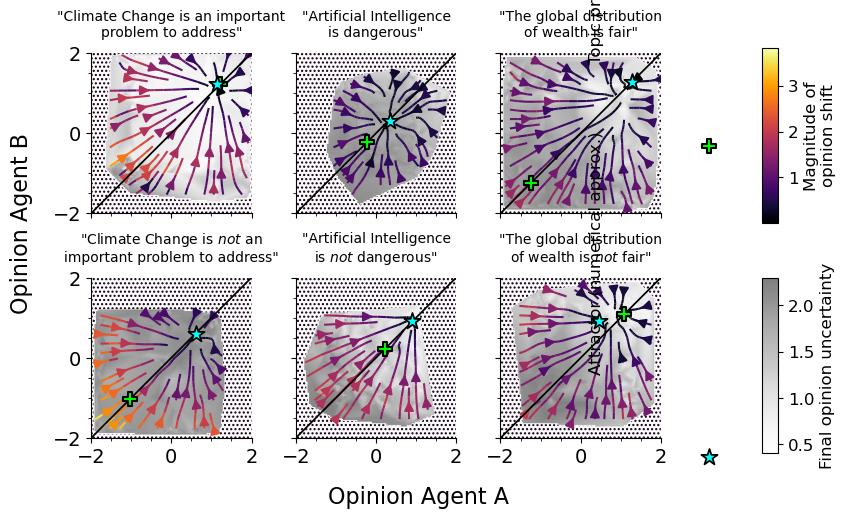

In [7]:
grid_x, grid_y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
rev_label = ['', '(Rev. Framing)\n']
topic_priors = priors_exp

# Define color maps
cmap_stream = 'inferno'  # for streamlines
cmap = plt.cm.Greys  # or any other colormap for entropy

from matplotlib.patches import Rectangle
cmap_entropy = plt.cm.Greys.copy()
cmap_entropy.set_bad((1, 1, 1, 0))  # fully transparent for NaNs

# Create a figure with a 3x2 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(8, 5), sharex='all', sharey='all')

# Normalize colorbars
from matplotlib.colors import Normalize
norm_magnitude = Normalize(vmin=np.nanmin(all_grids[:,2]), vmax=np.nanmax(all_grids[:,2]))
norm_entropy = Normalize(vmin=np.nanmin(all_grids[:,3]), vmax=np.nanmax(all_grids[:,3]))


all_topics = ['"Climate Change is an important\nproblem to address"', '"Artificial Intelligence\nis dangerous"', '"The global distribution\nof wealth is fair"', 
              '"Climate Change is ' + r'$\it{not}$' + ' an\nimportant problem to address"', '"Artificial Intelligence\nis ' + r'$\it{not}$' + ' dangerous"', 
              '"The global distribution\nof wealth is ' + r'$\it{not}$' + ' fair"' ]


# Iterate over axes and plot
for i, ax in enumerate(axes.flat):

    # Plot interpolated entropy as background 
    Z = all_grids[i, 3]
    Z_ma = np.ma.masked_invalid(Z)
    img = ax.imshow(Z_ma, extent=(-2, 2, -2, 2), origin='lower', cmap=cmap_entropy,
                    alpha=0.5, aspect='auto', norm=norm_entropy)
    
    nodata = Z_ma.mask.astype(float)
    ax.contourf(grid_x, grid_y, nodata, levels=[0.5, 1.5], colors='magenta', alpha=0.025,
            hatches=['....'],
            zorder=0)


    # Plotting the streamlines with magnitude as color
    stream = ax.streamplot(grid_x, grid_y, all_grids[i, 0], all_grids[i, 1], color=all_grids[i, 2], linewidth=1.5,cmap=cmap_stream, density=0.6, arrowsize=1.4, norm=norm_magnitude)


     # plot topic priors
    ax.scatter(topic_priors[i], topic_priors[i], s=100, color='lime', marker='P', edgecolors='black', lw=1.5, zorder=11, label='Topic prior')


    # --- Divergence (∂u/∂x + ∂v/∂y) -------------------------------------------
    U = all_grids[i, 0]
    V = all_grids[i, 1]

    dx = grid_x[0, 1] - grid_x[0, 0]
    dy = grid_y[1, 0] - grid_y[0, 0]

    dU_dy, dU_dx = np.gradient(U, dy, dx, edge_order=2)
    dV_dy, dV_dx = np.gradient(V, dy, dx, edge_order=2)
    div = dU_dx + dV_dy  # negative ⇒ locally contracting

    # --- Numeric guess for a sink (near-zero speed + negative divergence) ---
    speed = all_grids[i, 2]  
    cand = np.where(np.isfinite(speed) & np.isfinite(div) & (div < 0))

    if cand[0].size:
        j0 = cand[0][np.argmin(speed[cand])]
        k0 = cand[1][np.argmin(speed[cand])]
        ax.scatter(grid_x[j0, k0], grid_y[j0, k0],
                s=150, color='cyan', marker='*', edgecolors='black', lw=1.25,
                zorder=12, label='Attractor (numerical approx.)')

    # Optional: draw the zero-divergence contour (boundary between source/sink regions)
    #ax.contour(grid_x, grid_y, div, levels=[0], colors='k', linewidths=0.8, alpha=0.6)

    # May need to be adjusted depending on model
    ax.set_xticks(range(-2, 3))
    ax.set_yticks(range(-2, 3))
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)

    ax.tick_params(axis='both', labelsize=14)

    ax.set_xticks([-2, 0, 2])  # Major ticks
    ax.set_yticks([-2, 0, 2])  # Major ticks

    ax.set_xticks(np.linspace(-2, 2, 9), minor=True)  # Minor ticks
    ax.set_yticks(np.linspace(-2, 2, 9), minor=True)  # Minor ticks

    # Remove minor tick labels
    ax.tick_params(axis='both', which='minor', labelbottom=False, labelleft=False)

    ax.set_aspect('equal')
    ax.set_title(f'{all_topics[i]}', fontsize=10, y=1.05)  # Adjust as needed for each subplot

    if i == 5:
        legend = ax.legend(loc='center left', bbox_to_anchor=(1.1, 1.075), labelspacing=4, frameon=False, 
                           fontsize=12, ncols=1)
        for text in legend.get_texts():
            text.set_rotation(90)
            text.set_position((-150, 90))
    
    ax.spines[['right', 'top']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('black')
    
    ax.plot([-2, 2], [-2, 2], ls='-', color='black', alpha=1, lw=1.25)

# Create colorbars
fig.subplots_adjust(right=0.85)

cbar_ax_stream = fig.add_axes([0.97, 0.54, 0.02, 0.35])  
cbar_ax_entropy = fig.add_axes([0.97, 0.08, 0.02, 0.35]) 

fig.colorbar(stream.lines, cax=cbar_ax_stream, orientation='vertical').set_label('Magnitude of\nopinion shift', size=12)
fig.colorbar(img, cax=cbar_ax_entropy, orientation='vertical').set_label('Final opinion uncertainty', size=12)

# set ticklabel size of colorbars
cbar_ax_stream.tick_params(labelsize=12)
cbar_ax_entropy.tick_params(labelsize=12)

fig.supxlabel('Opinion Agent A', y=-0.03, x=0.54, fontsize=16)
fig.supylabel('Opinion Agent B', x=0.03, y=0.54, fontsize=16)

plt.subplots_adjust(hspace=0.4)
plt.savefig('../../plots/figure_2.png', dpi=400, bbox_inches='tight')
plt.show()

In [8]:
# With plt.show() you get some formatting issues, but inside the png file the legends are positioned where they should